# Import

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import pickle
import torch
import os
import gc
import glob
import scipy.signal
import math
import json
import matplotlib.colors as mcolors
from scipy.signal import butter, filtfilt
from concurrent.futures import ThreadPoolExecutor, as_completed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from types import SimpleNamespace
import _MultiResUNet as MultiResUNet
import torch.nn as nn
import torch.optim as optim
import os
import pickle
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt                  
import numpy as np

In [2]:
PREFIX = '1_'   # model prefix
TEST_DIR = "test"
class_names = ['ramp ascent', 'ramp descent', 'stair ascent', 'stair descent', 'walk']
CUTOFF_FREQ = 25

In [3]:
def load_config(filename):
    save_path = os.path.join(os.path.join('model', PREFIX), filename)
    with open(save_path, 'r') as f:
        config_dict = json.load(f)
    return SimpleNamespace(**config_dict)

config = load_config(PREFIX + 'config.json')
SAVE_DIR = os.path.join(config.SAVE_DIR, PREFIX)

In [4]:
# MAX_LENGTH_TARGET를 2 ** model_depth의 배수로 설정
factor = 2 ** config.model_depth
MAX_LENGTH_TARGET = math.ceil((config.SAMPLE_RATE_TARGET * config.MAX_TIME) / factor) * factor
print(f'Max recording time: {MAX_LENGTH_TARGET/config.SAMPLE_RATE_TARGET} sec')

Max recording time: 51.2 sec


# Make Examples

# Feature Engineering

In [5]:
class TimeSeriesFeatureEngineer:
    def __init__(self, window_sizes, sampling_rate):
        self.window_sizes = np.dot(window_sizes, sampling_rate).astype(int)
        self.encoder = None
        self.label_mapping = {
            'idle': 'walk',
            'rampascent': 'rampascent',
            'rampascent-walk': 'rampascent',
            'rampdescent': 'rampdescent',
            'rampdescent-walk': 'rampdescent',
            'stairascent': 'stairascent',
            'stairascent-walk': 'stairascent',
            'stairdescent': 'stairdescent',
            'stairdescent-walk': 'stairdescent',
            'stand': 'walk',
            'stand-walk': 'walk',
            'turn1': 'walk',
            'turn2': 'walk',
            'walk': 'walk',
            'walk-rampascent': 'rampascent',
            'walk-rampdescent': 'rampdescent',
            'walk-stairascent': 'stairascent',
            'walk-stairdescent': 'stairdescent',
            'walk-stand': 'walk'
        }

    def map_labels(self, Y_data):
        Y_data_mapped = []
        for y_seq in Y_data:
            Y_data_mapped.append(np.array([self.label_mapping[label] for label in y_seq]))
        return Y_data_mapped

    def create_encoder(self, Y_data):
        # 라벨 매핑
        Y_data_mapped = self.map_labels(Y_data)
        
        # 전체 라벨 수집
        all_labels = np.concatenate(Y_data_mapped)
        all_labels_unique = np.unique(all_labels).reshape(-1, 1)
        
        # OneHotEncoder를 사용하여 라벨 인코딩
        self.encoder = OneHotEncoder(sparse_output=False)
        self.encoder.fit(all_labels_unique)

        # 인코더의 라벨 출력
        print("Encoder classes:", self.encoder.categories_)
        return self.encoder

    def fit_transform_labels(self, Y_data):
        if self.encoder is None:
            raise ValueError("Encoder has not been created. Call create_encoder first.")
        
        # 라벨 매핑
        Y_data_mapped = self.map_labels(Y_data)
        
        # 각 Y_data를 원핫 인코딩
        Y_data_encoded_list = [self.encoder.transform(np.array(y).reshape(-1, 1)) for y in Y_data_mapped]
        return Y_data_encoded_list

    def feature_engineering(self, df: pl.DataFrame):
        # LazyFrame으로 변환하여 작업
        lf = df.lazy()
        
        for col in df.columns:
            for window in self.window_sizes:
                window_str = str(window)
                # 통계 값
                lf = lf.with_columns([
                    df[col].rolling_mean(window).alias(col + '_mean_' + window_str),
                    df[col].rolling_std(window).alias(col + '_std_' + window_str),
                    df[col].rolling_min(window).alias(col + '_min_' + window_str),
                    df[col].rolling_max(window).alias(col + '_max_' + window_str),
                    df[col].diff(window).alias(col + '_diff_' + window_str)
                ])
                for lag in [1, 2, 3, 4, 5]:
                    lf = lf.with_columns([
                        df[col].shift(lag * window).alias(col + f'_lag_{lag}_' + window_str)
                    ])
        
        features_df = lf.collect().fill_nan(0).fill_null(0)
        return features_df

    def fit_transform_features(self, X_data):
        X_features = []
        for seq in X_data:
            seq_df = pl.DataFrame(seq)
            features_df = self.feature_engineering(seq_df)
            X_features.append(features_df.to_numpy())
        return X_features
    
    def resample_x_data(self, X_data, original_sampling_rate, target_sampling_rate):
        resampled_X_data = []
        for seq in X_data:
            num_samples = int(len(seq) * target_sampling_rate / original_sampling_rate)
            resampled_seq = scipy.signal.resample(seq, num_samples)
            resampled_X_data.append(resampled_seq)
        return resampled_X_data

    def resample_y_data(self, Y_data, original_sampling_rate, target_sampling_rate):
        resampled_Y_data = []
        for seq in Y_data:
            num_samples = int(len(seq) * target_sampling_rate / original_sampling_rate)
            resampled_seq = np.zeros((num_samples, seq.shape[1]))
            for i in range(seq.shape[1]):
                resampled_seq[:, i] = np.round(scipy.signal.resample(seq[:, i], num_samples))
            resampled_Y_data.append(resampled_seq)
        return resampled_Y_data

    def fit(self, X_data, Y_data, original_sampling_rate, target_sampling_rate, train_dir="train_batches", val_dir="val_batches", test_size=0.2, max_workers=4):
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(val_dir, exist_ok=True)

        # 라벨 인코딩
        self.create_encoder(Y_data)
        Y_data_encoded = self.fit_transform_labels(Y_data)

        # Resample the data
        X_data_resampled = self.resample_x_data(X_data, original_sampling_rate, target_sampling_rate)
        Y_data_resampled = self.resample_y_data(Y_data_encoded, original_sampling_rate, target_sampling_rate)

        # Statistics
        sequence_length = [len(seq) for seq in X_data_resampled]
        print(f'Max sequence length: {max(sequence_length)}')
        print(f'Min sequence length: {min(sequence_length)}')
        print(f'Mean sequence length: {np.mean(sequence_length)}')

        # Train/Val split
        X_train, X_val, Y_train, Y_val = train_test_split(X_data_resampled, Y_data_resampled, test_size=test_size, random_state=42)

        # Train 데이터 저장
        self._process_and_save_individual(X_train, Y_train, train_dir, max_workers)
        # Val 데이터 저장
        self._process_and_save_individual(X_val, Y_val, val_dir, max_workers)

    def _process_and_save_individual(self, X_data, Y_data, save_dir, max_workers):
        def process_and_save(idx):
            X_features = self.fit_transform_features([X_data[idx]])[0]
            Y_encoded = Y_data[idx]
            
            with open(os.path.join(save_dir, f"X_data_{idx}.pkl"), 'wb') as f:
                pickle.dump(X_features, f)
            with open(os.path.join(save_dir, f"Y_data_{idx}.pkl"), 'wb') as f:
                pickle.dump(Y_encoded, f)
            
            del X_features, Y_encoded
            gc.collect()

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [executor.submit(process_and_save, idx) for idx in range(len(X_data))]
            for _ in tqdm(as_completed(futures), total=len(futures), desc=f"Processing data in {save_dir}", unit="sample"):
                pass

# Data Loader

In [6]:
def interpolate_time_series(df, sample_rate_target):
    # 시간 열 찾기
    time_col = None
    for col in ['time', 'Time', 'Timestamp(s)', 'Header']:
        if col in df.columns:
            time_col = col
            break
    
    if time_col is None:
        raise ValueError("No time column found in the dataframe")
    
    # 시간 열을 초 단위로 변환
    time = df[time_col].values
    time = time - time[0]  # 시간 축을 0부터 시작하게 변경
    
    # 목표 샘플링 레이트에 따라 새로운 시간축 생성
    duration = time[-1]
    num_samples = int(duration * sample_rate_target)
    new_time = np.linspace(0, duration, num_samples)
    
    # 보간 수행
    interpolated_df = pd.DataFrame({time_col: new_time})
    for col in df.columns:
        if col != time_col:
            interpolated_df[col] = np.interp(new_time, time, df[col].values)
    
    return interpolated_df

def convert_units(df):
    # 가속도 데이터를 g 단위로 변환 (1 g ≈ 9.81 m/s²)
    accel_columns = [col for col in df.columns if 'Accel' in col]
    for col in accel_columns:
        df[col] = df[col] / 9.81

    # 자이로스코프 데이터를 rad/s 단위로 변환 (1 dps = π/180 rad/s)
    gyro_columns = [col for col in df.columns if 'Gyro' in col]
    for col in gyro_columns:
        df[col] = df[col] * (3.141592653589793 / 180)
    
    return df

def lowpass_filter(data, cutoff_freq=100, sampling_rate=200, filter_order=6):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(filter_order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Load CSV files and apply feature engineering
def load_and_process_csv_files(test_folder, sample_rate_target):
    required_columns = [
        'foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z', 'foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z',
        'shank_Accel_X', 'shank_Accel_Y', 'shank_Accel_Z', 'shank_Gyro_X', 'shank_Gyro_Y', 'shank_Gyro_Z',
        'thigh_Accel_X', 'thigh_Accel_Y', 'thigh_Accel_Z', 'thigh_Gyro_X', 'thigh_Gyro_Y', 'thigh_Gyro_Z',
        'trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z', 'trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z'
    ]
    
    csv_files = sorted(glob.glob(os.path.join(test_folder, '*.csv')))
    X_data = []
    
    for file in tqdm(csv_files, desc="Loading CSV files"):
        df = pd.read_csv(file)
        # 보간 수행
        df = interpolate_time_series(df, sample_rate_target)
        # 단위 변환
        if not test_folder == 'test__opendata':
            df = convert_units(df)
            # 저역 통과 필터 적용
            if sample_rate_target > CUTOFF_FREQ:
                for column in required_columns:
                    df[column] = lowpass_filter(df[column], cutoff_freq=CUTOFF_FREQ, sampling_rate=sample_rate_target, filter_order=6)
                
        # 지정된 컬럼 순서대로 정렬하고 나머지 컬럼 드랍
        df = df[required_columns]
        X_data.append(df)
    
    return X_data

class TestTimeSeriesDataset(Dataset):
    def __init__(self, test_folder, feature_engineer, max_length, sample_rate_target):
        self.X_data = load_and_process_csv_files(test_folder, sample_rate_target)
        self.X_data = feature_engineer.fit_transform_features(self.X_data)
        self.max_length = max_length

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        X_data = self.X_data[idx]
        X_padded, mask = self.pad_or_trim_sequence(X_data)
        return X_padded, mask

    def pad_or_trim_sequence(self, sequence):
        seq_len = len(sequence)
        feature_dim = sequence.shape[1] if len(sequence.shape) > 1 else 1

        if seq_len > self.max_length:
            trimmed_seq = sequence[:self.max_length]
            mask = np.ones(self.max_length, dtype=int)
            return torch.tensor(trimmed_seq, dtype=torch.float32), torch.tensor(mask, dtype=torch.int64)
        else:
            padding_length = self.max_length - seq_len
            if feature_dim > 1:
                padded_seq = np.pad(sequence, ((0, padding_length), (0, 0)), 'constant', constant_values=0)
            else:
                padded_seq = np.pad(sequence, (0, padding_length), 'constant', constant_values=0)
            mask = np.concatenate((np.ones(seq_len, dtype=int), np.zeros(padding_length, dtype=int)))
            return torch.tensor(padded_seq, dtype=torch.float32), torch.tensor(mask, dtype=torch.int64)


In [7]:
# Define parameters
feature_engineer = TimeSeriesFeatureEngineer(config.WINDOW_SIZES, config.SAMPLE_RATE_TARGET)

# Create the test dataset and data loader
test_dataset = TestTimeSeriesDataset(test_folder=TEST_DIR, feature_engineer=feature_engineer, max_length=MAX_LENGTH_TARGET, sample_rate_target=config.SAMPLE_RATE_TARGET)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Loading CSV files: 100%|██████████| 10/10 [00:00<00:00, 92.03it/s]


In [8]:
# # Example usage
# for X_batch in test_loader:
#     print(X_batch.shape)
#     pass

# Eval

In [9]:
def predict(model, data_loader, filter_type=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_preds = []
    all_probabilities = []
    
    with torch.no_grad():
        for X_batch, mask in data_loader:
            X_batch = X_batch.to(device)
            mask = mask.to(device)

            with autocast():
                outputs = model(X_batch)
                if isinstance(outputs, list):  # Deep Supervision
                    outputs = outputs[-1]  # Use the last output

                probs = torch.softmax(outputs, dim=2)  # Calculate probabilities for each class
                probs = probs.cpu().numpy()

                if filter_type is None:
                    filtered_probs = probs
                elif filter_type == 'lowpass':
                    # Apply lowpass filter
                    filtered_probs = np.zeros_like(probs)
                    for i in range(probs.shape[2]):
                        for j in range(probs.shape[0]):
                            filtered_probs[j, :, i] = lowpass_filter(probs[j, :, i], cutoff_freq=1000/config.SAMPLE_RATE_TARGET, sampling_rate=config.SAMPLE_RATE_TARGET, filter_order=4)
                else:
                    raise ValueError("Invalid filter_type. Choose 'lowpass'.")

                # Apply mask to filtered probabilities
                masked_probs = [filtered_probs[j, mask[j].cpu().numpy() == 1] for j in range(filtered_probs.shape[0])]

                preds = [np.argmax(p, axis=1) for p in masked_probs]  # Get predicted class indices

                all_preds.extend(preds)
                all_probabilities.extend(masked_probs)
    
    return all_preds, all_probabilities

In [10]:
def plot_probabilities(pred_labels, probabilities, class_names, save_dir, idx):
    num_classes = len(class_names)
    time_steps = probabilities.shape[0]

    fig, axes = plt.subplots(num_classes, 1, figsize=(10, num_classes * 2), sharex=True)

    if num_classes == 1:
        axes = [axes]

    # Create one-hot encoded predicted labels
    pred_labels_one_hot = np.zeros((time_steps, num_classes))
    for t in range(len(pred_labels)):
        pred_labels_one_hot[t, pred_labels[t]] = 1

    color_prob = '#4A4A4A'  # Dark Gray
    color_pred = '#F08080'  # Light Coral

    for i, class_name in enumerate(class_names):
        axes[i].plot(range(len(probabilities)), probabilities[:, i], label='Probability', alpha=0.6, color=color_prob)
        axes[i].fill_between(range(len(probabilities)), 0, probabilities[:, i], alpha=0.2, color=color_prob)
        axes[i].plot(range(len(pred_labels_one_hot)), pred_labels_one_hot[:, i], linestyle='dotted', label='Predicted', alpha=0.6, color=color_pred)
        axes[i].fill_between(range(len(pred_labels_one_hot)), 0, pred_labels_one_hot[:, i], alpha=0.2, color=color_pred)
                
        axes[i].set_ylabel('Probability', fontsize=14)
        axes[i].set_ylim(0, 1)
        axes[i].set_title(class_name, fontsize=18)
        axes[i].legend(fontsize=14)

    axes[-1].set_xlabel('Time Steps', fontsize=14)

    fig.suptitle(f'{idx}th Result', fontsize=24, y=0.99, x=0.85)
    plt.tight_layout(rect=[0, 0, 1, 1.02])

    # Ensure save directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_path = os.path.join(save_dir, f'test_{idx}_probabilities.png')
    plt.savefig(save_path, dpi=300)
    plt.close()

In [11]:
def plot_probabilities_for_all_trials(pred_labels, probabilities, class_names, save_dir):
    total_plots = len(probabilities)
    for idx in tqdm(range(total_plots), desc="Plotting probabilities", unit="plot"):
        plot_probabilities(pred_labels[idx], probabilities[idx], class_names, save_dir, idx)


In [12]:
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [13]:
# 데이터 로더를 사용하여 모델의 길이, 채널 수 및 출력 채널 수 설정
length = test_loader.dataset.X_data[0].shape[0]
num_channel = test_loader.dataset.X_data[0].shape[1]
output_channels = len(class_names)

In [14]:
model = MultiResUNet.UNet(length=length, model_depth=config.model_depth, num_channel=num_channel, model_width=config.model_width, kernel_size=config.kernel_size, problem_type=config.problem_type, output_channels=output_channels, ds=config.ds, ae=config.ae, feature_number=config.feature_number, is_transconv=config.is_transconv)

criterion = torch.nn.BCEWithLogitsLoss() 

loaded_model = load_model(model, os.path.join(SAVE_DIR, PREFIX+'best_model_checkpoint.pth'))

In [15]:
all_preds, all_probabilities = predict(model, test_loader)
plot_probabilities_for_all_trials(all_preds, all_probabilities, class_names, save_dir=TEST_DIR)

/home/awear-omen/miniforge3/envs/RT5307/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
Plotting probabilities: 100%|██████████| 10/10 [00:05<00:00,  1.86plot/s]


# Data Plot

In [16]:
# Plot
def plot_nth_batch(data_list, n, sample_rate_target, start_time=None, end_time=None):
    if n >= len(data_list):
        print(f"Error: The dataset only has {len(data_list)} batches.")
        return
    
    # DataFrame 배열로 변환
    df_original = data_list[n]
    
    # 시간 축 생성
    total_samples = len(df_original)
    time_index = np.arange(total_samples) / sample_rate_target
    
    # 시간 범위가 지정되지 않으면 전체 데이터 사용
    if start_time is None or end_time is None:
        start_time = time_index[0]
        end_time = time_index[-1]

    # 시간 범위로 데이터 선택
    mask = (time_index >= start_time) & (time_index <= end_time)
    selected_data = df_original[mask]
    selected_time = time_index[mask]

    # 각 센서 데이터 플롯
    plt.figure(figsize=(20, 30))
    sensor_groups = {
        'foot_Accel': ['foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z'],
        'foot_Gyro': ['foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z'],
        'shank_Accel': ['shank_Accel_X', 'shank_Accel_Y', 'shank_Accel_Z'],
        'shank_Gyro': ['shank_Gyro_X', 'shank_Gyro_Y', 'shank_Gyro_Z'],
        'thigh_Accel': ['thigh_Accel_X', 'thigh_Accel_Y', 'thigh_Accel_Z'],
        'thigh_Gyro': ['thigh_Gyro_X', 'thigh_Gyro_Y', 'thigh_Gyro_Z'],
        'trunk_Accel': ['trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z'],
        'trunk_Gyro': ['trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z']
    }

    color_x = '#4A4A4A'  # Dark Gray
    color_y = '#00BFFF'  # Deep Sky Blue
    color_z = '#F08080'  # Light Coral

    for i, (sensor, labels) in enumerate(sensor_groups.items(), 1):
        plt.subplot(4, 2, i)
        for label in labels:
            if '_X' in label:
                color = color_x
            elif '_Y' in label:
                color = color_y
            else:
                color = color_z
            plt.plot(selected_time, selected_data[label], label=label, linestyle='-', color=color)
        plt.xlabel('Time (s)')
        plt.ylabel('Sensor Readings')
        plt.title(sensor)
        plt.legend()
        plt.grid(True)

    plt.show()


## Single

In [23]:
TEST_DIR = "test__opendata"
# TEST_DIR = "test"

Loading CSV files: 100%|██████████| 10/10 [00:00<00:00, 114.30it/s]


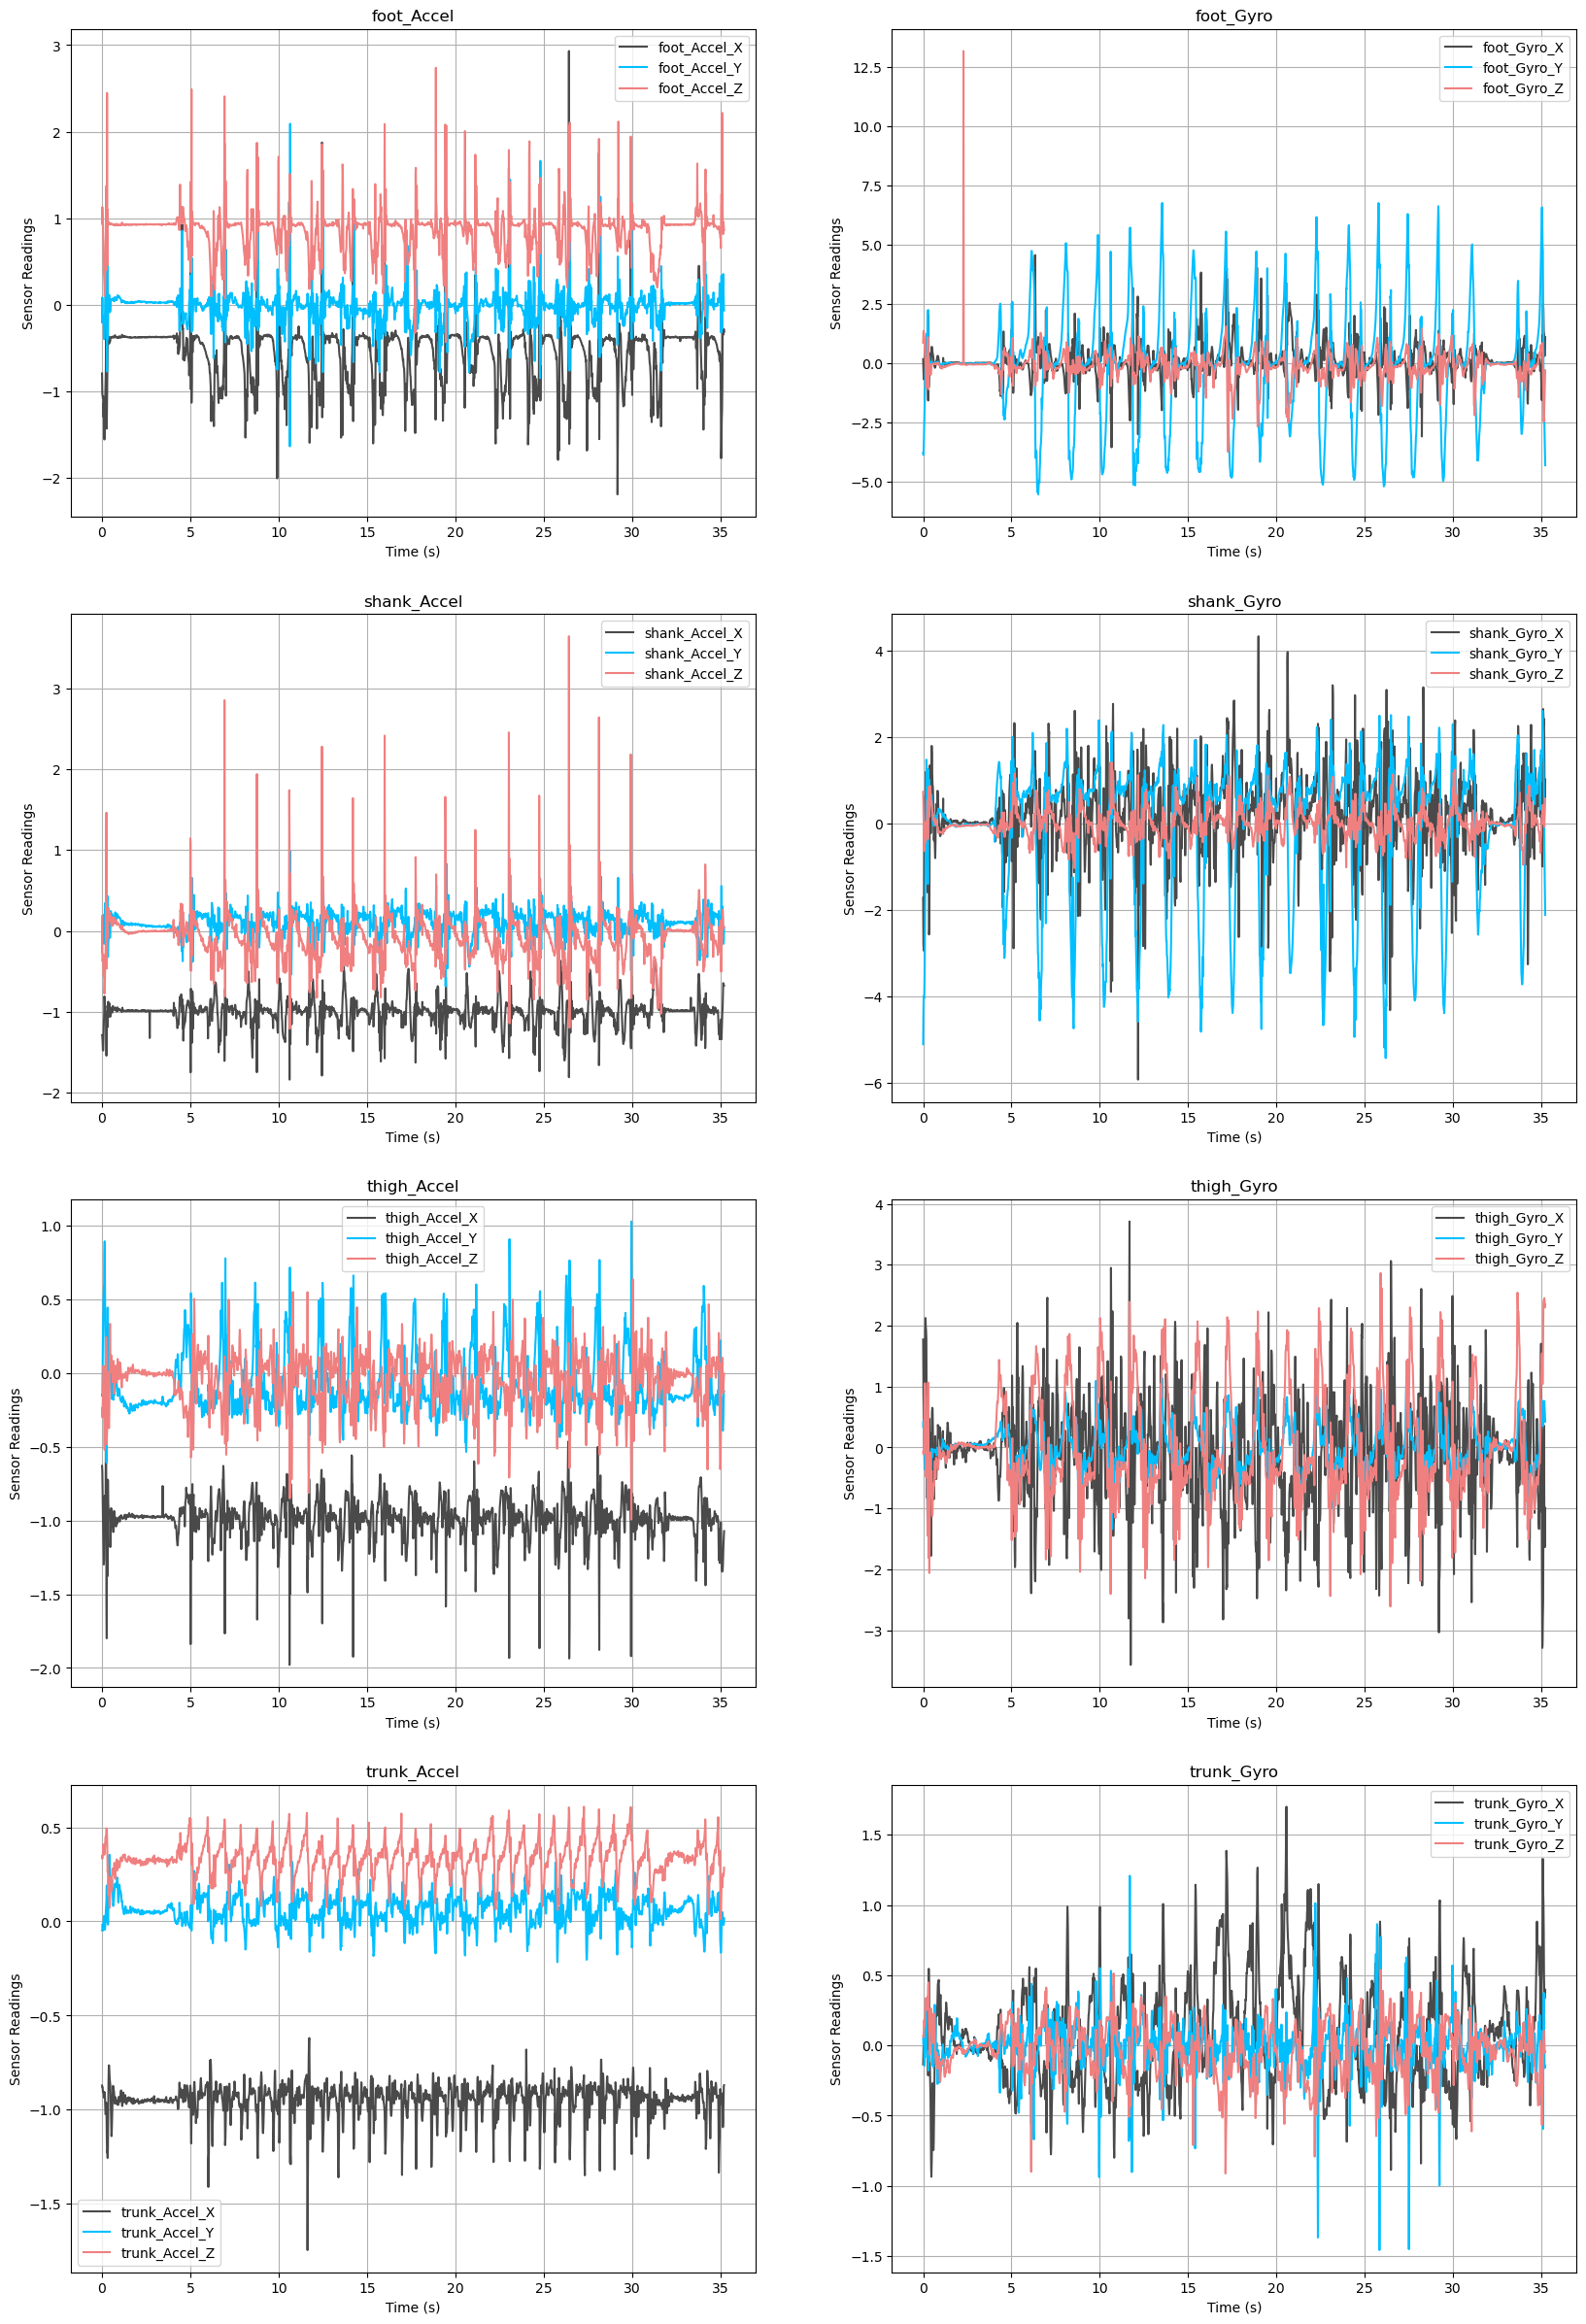

In [24]:
test_data_list = load_and_process_csv_files(TEST_DIR, config.SAMPLE_RATE_TARGET)
plot_nth_batch(test_data_list, n=3, sample_rate_target=config.SAMPLE_RATE_TARGET)    # start_time=4, end_time=5

## Comp

In [19]:
# Plot the comparison
def plot_nth_batch_comp(ax, data_list, n, sample_rate_target, start_time=None, end_time=None, linestyle='-'):
    if n >= len(data_list):
        print(f"Error: The dataset only has {len(data_list)} batches.")
        return
    
    # DataFrame 배열로 변환
    df_original = data_list[n]
    
    # 시간 축 생성
    total_samples = len(df_original)
    time_index = np.arange(total_samples) / sample_rate_target
    
    # 시간 범위가 지정되지 않으면 전체 데이터 사용
    if start_time is None or end_time is None:
        start_time = time_index[0]
        end_time = time_index[-1]

    # 시간 범위로 데이터 선택
    mask = (time_index >= start_time) & (time_index <= end_time)
    selected_data = df_original[mask]
    selected_time = time_index[mask]
    selected_time -= selected_time[0]  # 시작 시간을 0으로 맞춤

    # 각 센서 데이터 플롯
    sensor_groups = {
        'foot_Accel': ['foot_Accel_X', 'foot_Accel_Y', 'foot_Accel_Z'],
        'foot_Gyro': ['foot_Gyro_X', 'foot_Gyro_Y', 'foot_Gyro_Z'],
        'shank_Accel': ['shank_Accel_X', 'shank_Accel_Y', 'shank_Accel_Z'],
        'shank_Gyro': ['shank_Gyro_X', 'shank_Gyro_Y', 'shank_Gyro_Z'],
        'thigh_Accel': ['thigh_Accel_X', 'thigh_Accel_Y', 'thigh_Accel_Z'],
        'thigh_Gyro': ['thigh_Gyro_X', 'thigh_Gyro_Y', 'thigh_Gyro_Z'],
        'trunk_Accel': ['trunk_Accel_X', 'trunk_Accel_Y', 'trunk_Accel_Z'],
        'trunk_Gyro': ['trunk_Gyro_X', 'trunk_Gyro_Y', 'trunk_Gyro_Z']
    }

    color_x = '#4A4A4A'  # Dark Gray
    color_y = '#00BFFF'  # Deep Sky Blue
    color_z = '#F08080'  # Light Coral

    for i, (sensor, labels) in enumerate(sensor_groups.items(), 1):
        ax[i-1].set_title(sensor)
        for label in labels:
            if '_X' in label:
                color = color_x
            elif '_Y' in label:
                color = color_y
            else:
                color = color_z
            ax[i-1].plot(selected_time, selected_data[label], label=f"{label} ({linestyle})", linestyle=linestyle, color=color)
        ax[i-1].set_xlabel('Time (s)')
        ax[i-1].set_ylabel('Sensor Readings')
        ax[i-1].legend()
        ax[i-1].grid(True)

In [20]:
SAMPLE_RATE = 200

# Load and process CSV files
test_0_data_list = load_and_process_csv_files("test", SAMPLE_RATE)
test_1_data_list = load_and_process_csv_files("test__opendata", SAMPLE_RATE)

Loading CSV files: 100%|██████████| 10/10 [00:00<00:00, 111.34it/s]


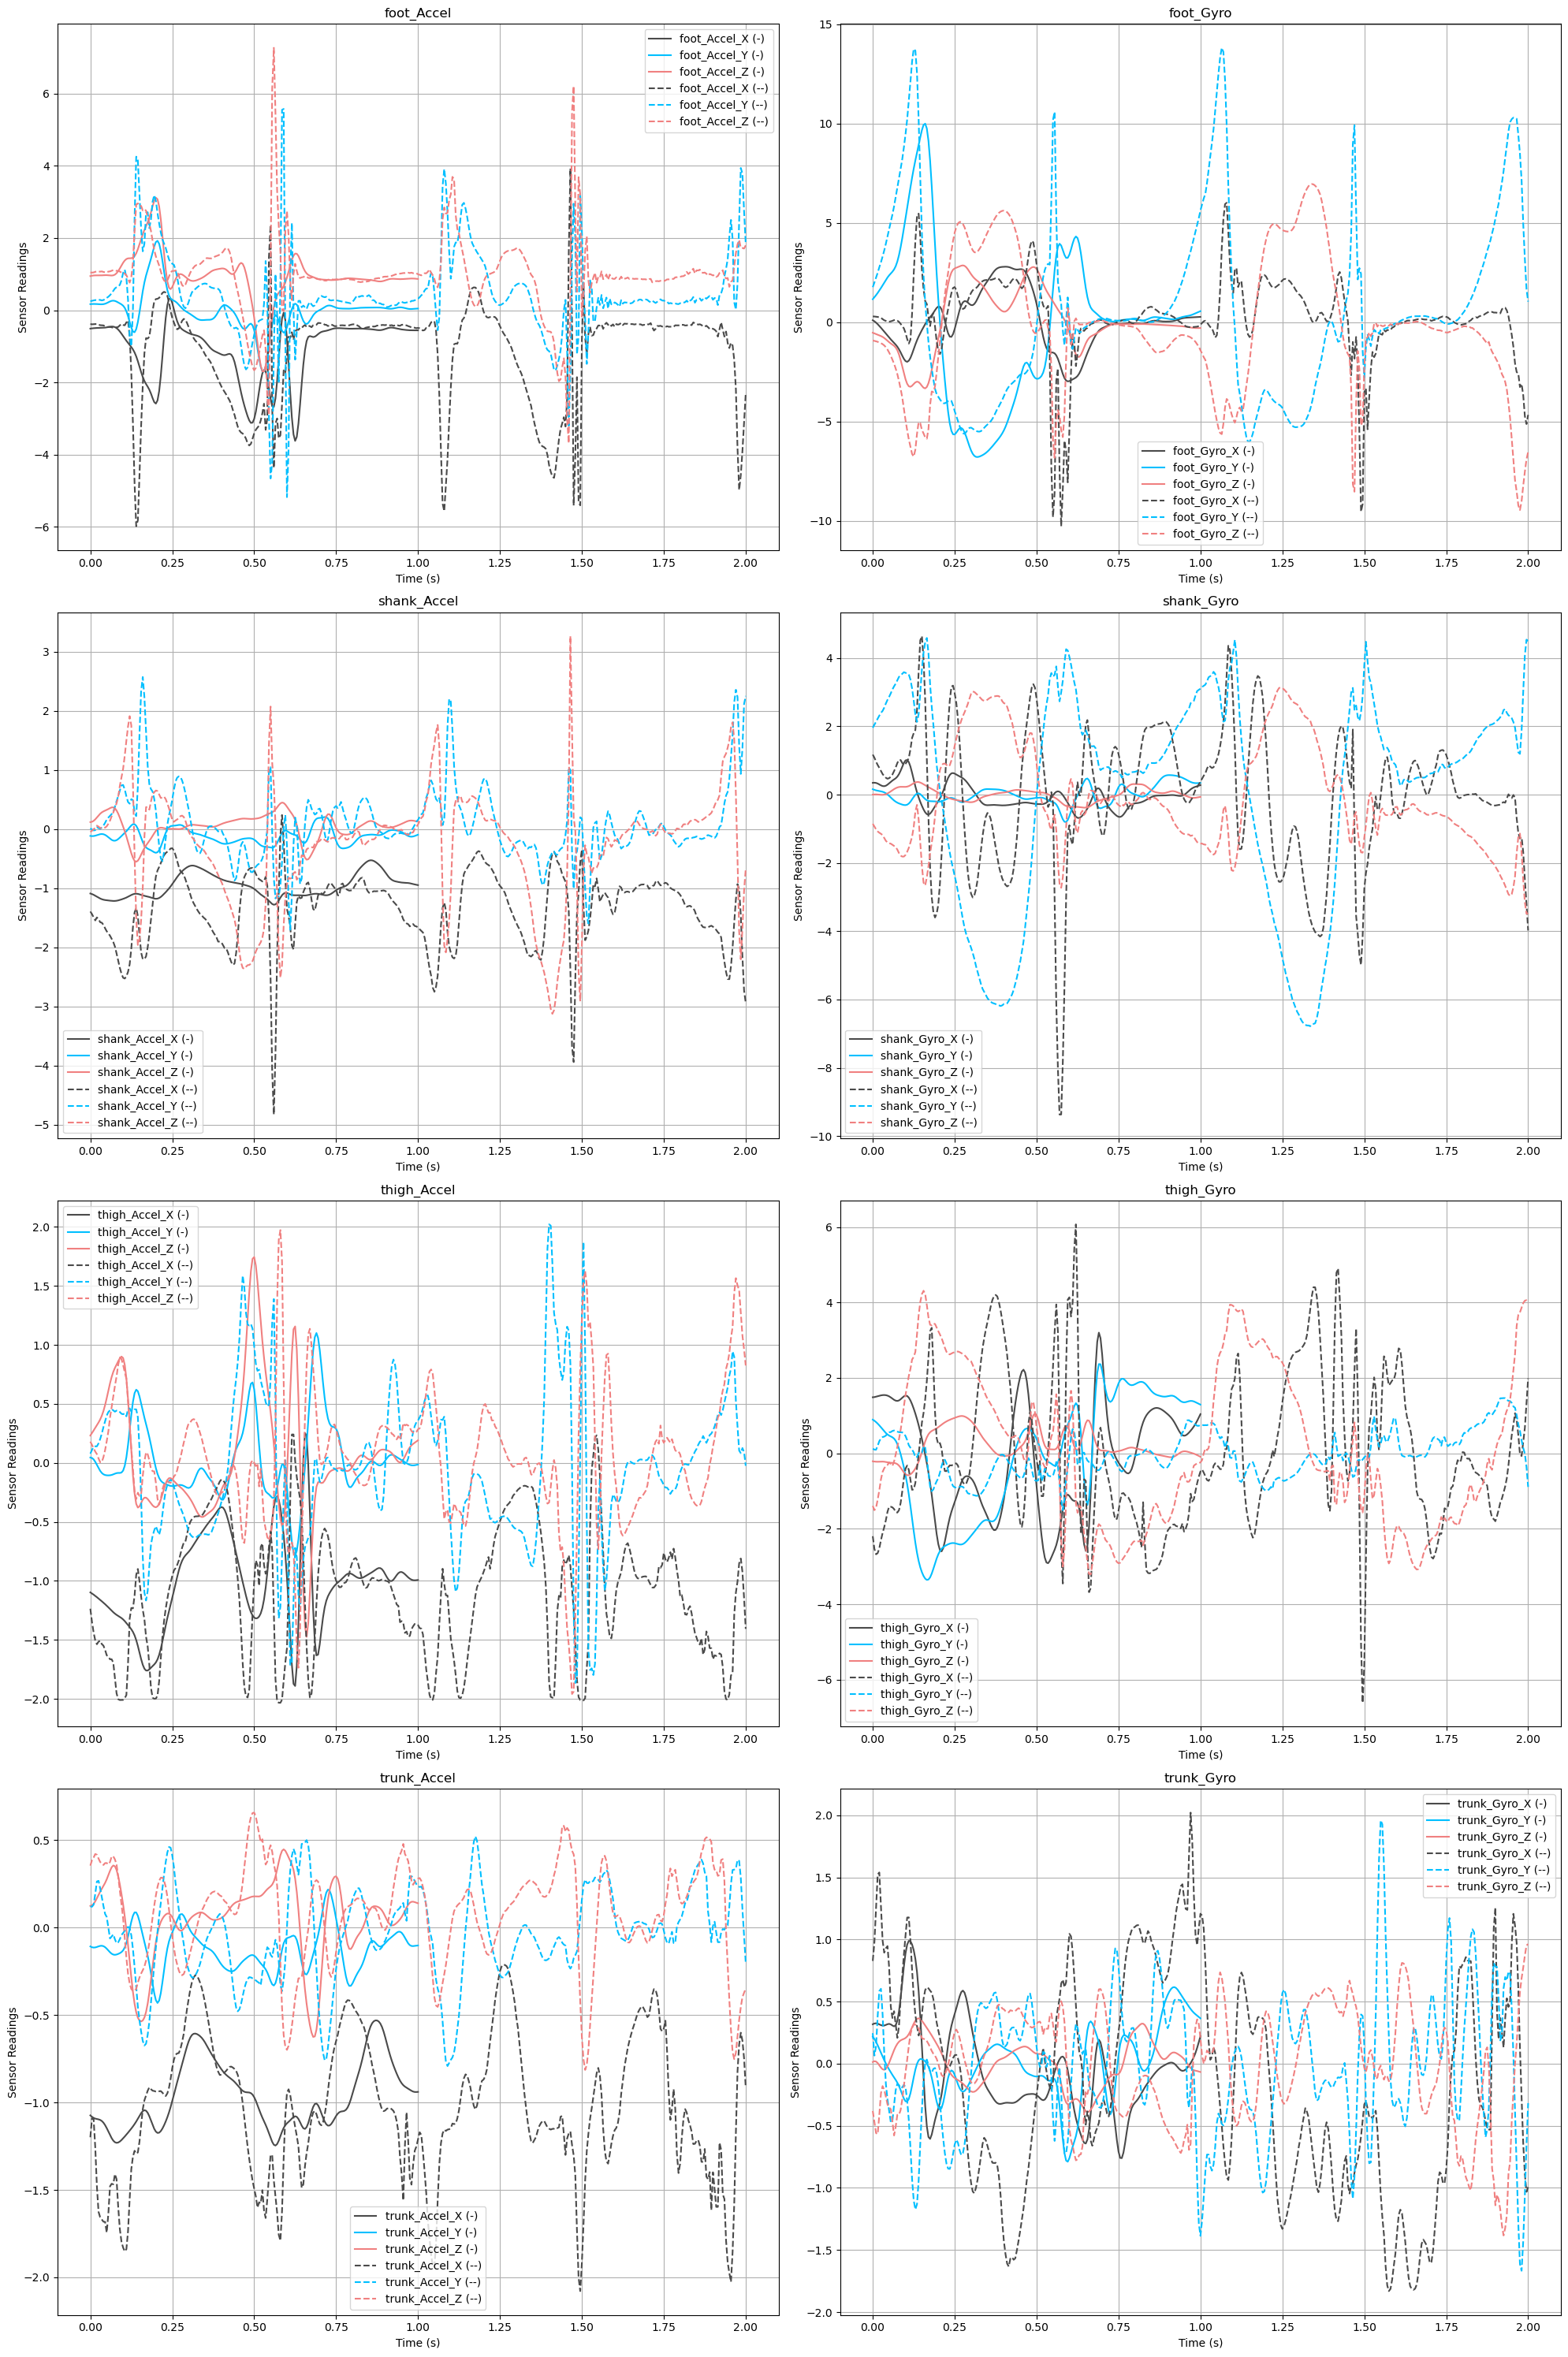

In [28]:
# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(20, 30))
axs = axs.flatten()

# Example usage: 두 개의 그래프를 같은 서브플롯 위치에 플롯
plot_nth_batch_comp(axs, test_0_data_list, n=0, sample_rate_target=SAMPLE_RATE, start_time=6.5, end_time=7.5, linestyle='-')
plot_nth_batch_comp(axs, test_1_data_list, n=0, sample_rate_target=SAMPLE_RATE, start_time=4.5, end_time=6.5, linestyle='--')

plt.tight_layout()
plt.show()